# Stanford Test Model

- Using local files in the building of the model for the moment
- Will at least attempt to include the meta data from the database hosted on AWS
- Need to solve how to use meta data with a raw string array of file numbers 
  - Probably need to iterate through the entire array and match files with their class number. Then later match class number      with actual class name
- Model can probably keep the same general stack as from the model for vehicle/nonvehicle
- Training images may need to be rotated again to help with the possibility of overfitting the data
- Remember that settings is a separate file that hides the database information in a separate file.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import sqlalchemy
import pandas as pd
from settings import db_string

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import psycopg2
from sqlalchemy import create_engine
engine = create_engine(db_string)

In [3]:
images_df = pd.read_sql_table('images', engine)
images_df.head()

,index,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,0,39,116,569,375,13.0,cars-traindataset/00001.jpg
1,1,36,116,868,587,2.0,cars-traindataset/00002.jpg
2,2,85,109,601,381,90.0,cars-traindataset/00003.jpg
3,3,621,393,1484,1096,133.0,cars-traindataset/00004.jpg
4,4,14,36,133,99,105.0,cars-traindataset/00005.jpg


In [4]:
labels_df = pd.read_sql_table('labels', engine)
labels_df.head()

,index,label
0,0,AM General Hummer SUV 2000
1,1,Acura RL Sedan 2012
2,2,Acura TL Sedan 2012
3,3,Acura TL Type-S 2008
4,4,Acura TSX Sedan 2012


In [5]:
import os
train_ds = os.listdir("cars_train/")
test_ds = os.listdir("cars_test/")
print(train_ds)

['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00035.jpg', '00036.jpg', '00037.jpg', '00038.jpg', '00039.jpg', '00040.jpg', '00041.jpg', '00042.jpg', '00043.jpg', '00044.jpg', '00045.jpg', '00046.jpg', '00047.jpg', '00048.jpg', '00049.jpg', '00050.jpg', '00051.jpg', '00052.jpg', '00053.jpg', '00054.jpg', '00055.jpg', '00056.jpg', '00057.jpg', '00058.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00065.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00074.jpg', '00075.jpg', '00076.jpg', '00077.jpg'

In [27]:
batch_size = 32
img_height = 180
img_width = 180
train_label = []

In [6]:
train_label = []
i = 0
for i in range(len(train_ds)):
   train_label.append(images_df.loc[images_df['fname'] ==("cars-traindataset/"+train_ds[i])]['class'].iloc[0])
   
print(train_label)

[13.0, 2.0, 90.0, 133.0, 105.0, 122.0, 88.0, 95.0, 166.0, 57.0, 48.0, 185.0, 134.0, 84.0, 192.0, 171.0, 13.0, 72.0, 191.0, 56.0, 78.0, 35.0, 119.0, 169.0, 193.0, 133.0, 183.0, 85.0, 179.0, 193.0, 153.0, 138.0, 65.0, 132.0, 153.0, 103.0, 37.0, 96.0, 104.0, 141.0, 12.0, 190.0, 118.0, 37.0, 185.0, 24.0, 193.0, 176.0, 172.0, 41.0, 90.0, 147.0, 14.0, 96.0, 41.0, 52.0, 43.0, 64.0, 89.0, 123.0, 113.0, 189.0, 100.0, 186.0, 7.0, 16.0, 110.0, 121.0, 4.0, 28.0, 125.0, 93.0, 105.0, 105.0, 187.0, 58.0, 109.0, 42.0, 132.0, 110.0, 7.0, 191.0, 17.0, 115.0, 48.0, 144.0, 48.0, 169.0, 19.0, 113.0, 164.0, 137.0, 174.0, 111.0, 121.0, 103.0, 56.0, 50.0, 36.0, 70.0, 192.0, 104.0, 60.0, 73.0, 132.0, 161.0, 130.0, 87.0, 120.0, 179.0, 179.0, 136.0, 132.0, 70.0, 82.0, 109.0, 41.0, 176.0, 146.0, 160.0, 108.0, 27.0, 143.0, 52.0, 28.0, 65.0, 78.0, 12.0, 135.0, 142.0, 170.0, 88.0, 134.0, 160.0, 57.0, 121.0, 177.0, 55.0, 183.0, 190.0, 39.0, 59.0, 154.0, 70.0, 139.0, 41.0, 75.0, 186.0, 85.0, 7.0, 4.0, 46.0, 29.0, 17.0

In [26]:
example = images_df.loc[images_df['fname'] ==("cars-traindataset/"+train_ds[0])]['class'].iloc[0]
print(example)

13.0


In [7]:
import pathlib
data_dir = "cars_train/"
data_dir = pathlib.Path(data_dir)

In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = train_label,  
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8144 files belonging to 1 classes.
Using 4887 files for training.


In [34]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels= train_label,   
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8144 files belonging to 1 classes.
Using 3257 files for validation.


In [35]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(196)
])

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [53]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
153/153 [==============================] - 53s 348ms/step - loss: 5.2769 - accuracy: 0.0063 - val_loss: 5.3035 - val_accuracy: 0.0089
Epoch 2/10
153/153 [==============================] - 51s 334ms/step - loss: 5.1852 - accuracy: 0.0137 - val_loss: 5.3952 - val_accuracy: 0.0080
Epoch 3/10
153/153 [==============================] - 51s 334ms/step - loss: 5.0240 - accuracy: 0.0301 - val_loss: 5.6911 - val_accuracy: 0.0068
Epoch 4/10
153/153 [==============================] - 51s 336ms/step - loss: 4.3583 - accuracy: 0.1123 - val_loss: 6.3885 - val_accuracy: 0.0046
Epoch 5/10
153/153 [==============================] - 51s 335ms/step - loss: 2.5278 - accuracy: 0.4236 - val_loss: 8.8838 - val_accuracy: 0.0046
Epoch 6/10
153/153 [==============================] - 51s 334ms/step - loss: 0.7694 - accuracy: 0.8261 - val_loss: 13.4646 - val_accuracy: 0.0061
Epoch 7/10
153/153 [==============================] - 51s 333ms/step - loss: 0.1574 - accuracy: 0.9699 - val_loss: 15.5554 - val_

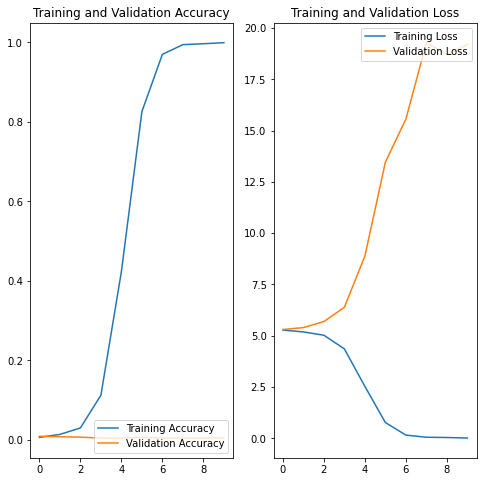

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Second Model Attempt
- Mostly trying to change batch sizing, image sizes, and the validation split to be much lower.


In [8]:
batch_size = 16
img_height = 240
img_width = 240

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = train_label,  
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8144 files belonging to 1 classes.
Using 6516 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels= train_label,   
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8144 files belonging to 1 classes.
Using 1628 files for validation.


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
model_2 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(196)
])

In [13]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [15]:
epochs=15
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
408/408 [==============================] - 136s 311ms/step - loss: 5.2622 - accuracy: 0.0080 - val_loss: 5.4224 - val_accuracy: 0.0080
Epoch 2/15
408/408 [==============================] - 133s 327ms/step - loss: 5.1444 - accuracy: 0.0172 - val_loss: 5.4529 - val_accuracy: 0.0068
Epoch 3/15
408/408 [==============================] - 126s 309ms/step - loss: 4.9215 - accuracy: 0.0399 - val_loss: 5.8994 - val_accuracy: 0.0055
Epoch 4/15
408/408 [==============================] - 121s 297ms/step - loss: 3.4728 - accuracy: 0.2514 - val_loss: 7.9268 - val_accuracy: 0.0055
Epoch 5/15
408/408 [==============================] - 125s 308ms/step - loss: 0.9754 - accuracy: 0.7776 - val_loss: 13.0008 - val_accuracy: 0.0037
Epoch 6/15
408/408 [==============================] - 126s 309ms/step - loss: 0.1697 - accuracy: 0.9715 - val_loss: 18.5106 - val_accuracy: 0.0031
Epoch 7/15
408/408 [==============================] - 127s 312ms/step - loss: 0.0696 - accuracy: 0.9932 - val_loss: 17.057

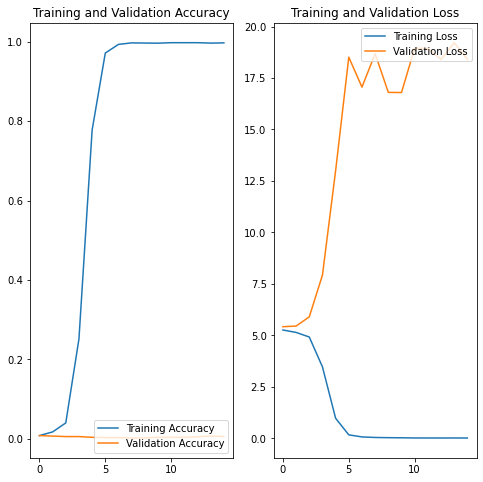

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Third Model
- Last model was an equivalent failure to the first
- Have to actively change layers in the model at this point to make something worth while.

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels = train_label,  
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8144 files belonging to 1 classes.
Using 4887 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels= train_label,   
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8144 files belonging to 1 classes.
Using 3257 files for validation.


In [23]:
model_3 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(196)
])

In [24]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)       

In [26]:
epochs=15
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
306/306 [==============================] - 107s 331ms/step - loss: 5.2868 - accuracy: 0.0059 - val_loss: 5.2771 - val_accuracy: 0.0074
Epoch 2/15
306/306 [==============================] - 100s 326ms/step - loss: 5.2774 - accuracy: 0.0072 - val_loss: 5.2758 - val_accuracy: 0.0068
Epoch 3/15
306/306 [==============================] - 99s 323ms/step - loss: 5.2753 - accuracy: 0.0086 - val_loss: 5.2751 - val_accuracy: 0.0068
Epoch 4/15
306/306 [==============================] - 99s 325ms/step - loss: 5.2446 - accuracy: 0.0121 - val_loss: 5.2955 - val_accuracy: 0.0058
Epoch 5/15
306/306 [==============================] - 99s 324ms/step - loss: 4.6787 - accuracy: 0.0845 - val_loss: 5.7882 - val_accuracy: 0.0046
Epoch 6/15
306/306 [==============================] - 100s 326ms/step - loss: 2.5416 - accuracy: 0.4520 - val_loss: 9.2438 - val_accuracy: 0.0080
Epoch 7/15
306/306 [==============================] - 100s 327ms/step - loss: 0.7381 - accuracy: 0.8281 - val_loss: 13.9731 - v

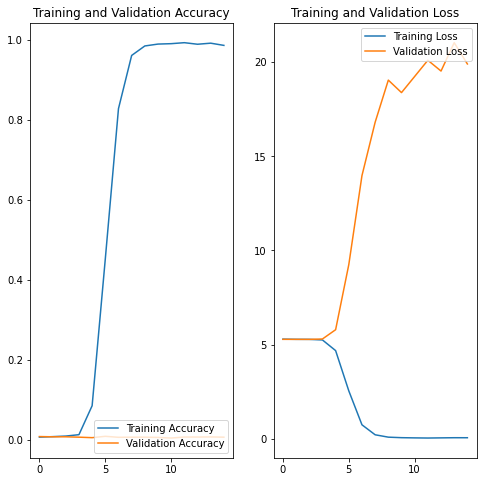

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Fourth Model
- I guess I need to maybe drop a layer of conv2d/max pooling?
- I honestly believe there isn't much I can do on the model end at this point and I need to just go ahead and give up and accept that I need to just rework how I input the data.
- I guess I'll change the activation to tanh for the sake of some difference.
- This all sucks.

In [28]:
model_4 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='tanh'),
  layers.Dense(196)
])

In [29]:
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 60, 60, 32)       

In [32]:
epochs=10
history = model_4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
306/306 [==============================] - 96s 313ms/step - loss: 5.4756 - accuracy: 0.0033 - val_loss: 5.3639 - val_accuracy: 0.0046
Epoch 2/10
306/306 [==============================] - 94s 306ms/step - loss: 5.4023 - accuracy: 0.0045 - val_loss: 5.3597 - val_accuracy: 0.0074
Epoch 3/10
306/306 [==============================] - 94s 308ms/step - loss: 5.3944 - accuracy: 0.0045 - val_loss: 5.3995 - val_accuracy: 0.0040
Epoch 4/10
306/306 [==============================] - 93s 305ms/step - loss: 5.3930 - accuracy: 0.0043 - val_loss: 5.3893 - val_accuracy: 0.0037
Epoch 5/10
306/306 [==============================] - 94s 307ms/step - loss: 5.3976 - accuracy: 0.0059 - val_loss: 5.3686 - val_accuracy: 0.0061
Epoch 6/10
306/306 [==============================] - 94s 306ms/step - loss: 5.3918 - accuracy: 0.0043 - val_loss: 5.3647 - val_accuracy: 0.0046
Epoch 7/10
306/306 [==============================] - 94s 307ms/step - loss: 5.3920 - accuracy: 0.0057 - val_loss: 5.3876 - val_ac

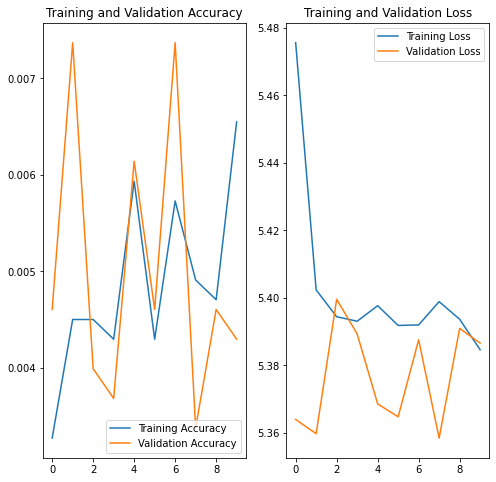

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 5th Model
- I got nothing man
- Relu activation is definitely more stable
- Removing a conv2d layer made it worse. Only answer is to add even more layers to this model now
- Fine tuning the model is the farthest thing from my mind.
- I need to remember to never ever copy and paste cells again because of this dumb validation error every time the model saves.